In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set1')
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import pydataset as data

from acquire import get_telco_data
from prepare import clean_telco_data, prep_telco_data

from env import get_db_url

α = .05

# Question: Is there a specific demographic group that is associated with more churn than expected??

## Goal: Find the main demographic drivers and their subgroups for Telco churn.

** I'd like to look into demographics first, as this wasn't subgroups I was able to explore last presentation project.

<u> Demographics I'll be looking at:</u>

- Senior citizens
- Single customers
- Customers with Partners
- Customers with Dependants
- Customers with Partner & Dependants

<u> Subgroups to compare once main demographic driver(s) are found, if I want to get more specific: </u>
- Gender
- monthly charges
- tenure
- account (internet) types
- automated vs non-automatic payment accounts

### Notes: By looking at the above demographics I want to find:
1) Highest churned demographic group (of the above)
- Note: I will first need to look at the group as whole (all churned and which group had most churns)
- Note: Then I should consider churn rate based with each group (example: senior citizens that have and have not churned rate)

# Getting to know my data:

In [2]:
#calling the dataframe
telco_df = get_telco_data()

In [3]:
#checking out dytpes
telco_df.dtypes

customer_id                    object
gender                         object
senior_citizen                  int64
partner                        object
dependents                     object
tenure                          int64
phone_service                  object
multiple_lines                 object
internet_service_type_id        int64
online_security                object
online_backup                  object
device_protection              object
tech_support                   object
streaming_tv                   object
streaming_movies               object
contract_type_id                int64
paperless_billing              object
payment_type_id                 int64
monthly_charges               float64
total_charges                  object
churn                          object
contract_type_id.1              int64
contract_type                  object
payment_type_id.1               int64
payment_type                   object
internet_service_type_id.1      int64
internet_ser

In [4]:
telco_df.columns.tolist()

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'internet_service_type_id',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract_type_id',
 'paperless_billing',
 'payment_type_id',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type_id.1',
 'contract_type',
 'payment_type_id.1',
 'payment_type',
 'internet_service_type_id.1',
 'internet_service_type']

In [5]:
#looking at numeric columns and statistical attributes
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
contract_type_id.1,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id.1,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id.1,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00


<b><u>Takeaways:</b></u>
- I can already see that later down the road, I am going to want to sort out my categorical columns vs numerical (for model testing)
- I know my target (y) will be churn...again, after exploring, I want to change that to a bool/numeric

In [6]:
train, validate, test = prep_telco_data(telco_df)
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
3270,4673-KKSLS,Female,No,No,No,31,Yes,No,Yes,No,...,0,0,0,0,0,0,1,0,1,0
6084,8623-ULFNQ,Female,Yes,No,No,26,Yes,Yes,No,No,...,0,1,1,0,0,0,1,0,0,0
4470,6303-KFWSL,Female,No,No,No,29,Yes,Yes,No,Yes,...,0,0,1,1,0,0,1,0,0,0
428,0623-IIHUG,Female,Yes,No,No,21,No,No phone service,Yes,No,...,0,0,1,0,0,0,1,0,0,0
3329,4742-DRORA,Male,No,Yes,Yes,60,Yes,Yes,Yes,No,...,0,0,1,1,0,0,0,0,1,0


In [7]:
#for senior citizen demographics: 
train.senior_citizen.value_counts()

#TAKE AWAYS: Senior-citizens customers make up 19% of Telco customers
           # 59 or younger customers make up 81% of Telco customers

No     3771
Yes     729
Name: senior_citizen, dtype: int64

In [8]:
#for clients with partners
train.partner.value_counts()

No     2317
Yes    2183
Name: partner, dtype: int64

In [9]:
#for clients with dependents
train.dependents.value_counts()

No     3142
Yes    1358
Name: dependents, dtype: int64

In [10]:
#for gender demographics:
train.gender.value_counts()

Male      2315
Female    2185
Name: gender, dtype: int64

In [11]:
#Let's look at the charts for these demographic customers:

## Questions I'm thinking:
-  Who do I think my drivers are? 
-  Why?
-  How can I look in/prove that?
-  Are there needed subgroups that I can use later on?
-  What can I get rid of?

Q: What/WHO do I think my drivers are?
- I know from the past that <b>non-automated accounts </b>were a major part of the churn, but I never found out WHO these people were.

#### <u>I want to know:</u>
- Their age, gender, and relationship status [get to know our churns and the probability of a certain demographic leaving]

Q: <i>Why would they churn?</i>
- Is it due only to their non-automated accounts or is there another reason within who they are?

Q: <i>How could I look at this?</i>
- Categorically: churn vs. demographic cateogries w/ chi2 tests and t-tests
- Visually: graphs, charts and accuracy rates in model

Q: <i>What subgroups do I think I will need to help me test churn and demographics?</i>
  - monthly charges (if I find a driver, I'd like to see a possible why within $$ the pay)
  - account types
  - non-automated accounts (to compare to last presentations findings)

## Next Steps:
- ✅ Creating range columns (for upcoming hypothesis testing) 
- ✅ PreProcessing Data (encoding any needed data)
- ✅ Prepping and splitting data to Explore and later Train on
- ✅ Explore some charts of the data (histograms comparing demographics)

In [12]:
# Percentage that Churned:

(train[train.churn == 'Yes'].count().churn / train.churn.shape[0]) * 100

#26.58% of customer churned this month.

26.57777777777778

In [13]:
#creating the columns for range in the statistical table of df
##used this great function from Faith Kane
def col_range(df):
    stats_df = telco_df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [14]:
col_range(telco_df)

,count,mean,std,min,25%,50%,75%,max,range
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00,1.0
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00,72.0
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00,2.0
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00,2.0
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00,3.0
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,100.5
contract_type_id.1,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00,2.0
payment_type_id.1,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00,3.0
internet_service_type_id.1,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00,2.0


## Preparing Data:

In [15]:
#plugging in our function called prep_telco_data from prepare.py file to cleanup data 
#and then telco_split to prepare for training
telco_df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,...,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,...,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [16]:
#dropping customer_id
train.select_dtypes('object').drop(columns = 'customer_id')

,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,contract_type,payment_type,internet_service_type
3270,Female,No,No,No,Yes,No,Yes,No,Yes,Yes,No,No,No,No,Month-to-month,Electronic check,Fiber optic
6084,Female,Yes,No,No,Yes,Yes,No,No,No,Yes,No,Yes,Yes,No,Month-to-month,Electronic check,DSL
4470,Female,No,No,No,Yes,Yes,No,Yes,No,No,No,No,Yes,No,One year,Electronic check,DSL
428,Female,Yes,No,No,No,No phone service,Yes,No,No,No,Yes,No,Yes,Yes,Month-to-month,Electronic check,DSL
3329,Male,No,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,No,One year,Bank transfer (automatic),Fiber optic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,Female,No,No,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Two year,Bank transfer (automatic),DSL
2421,Male,No,No,No,Yes,Yes,Yes,Yes,No,No,Yes,No,Yes,No,Month-to-month,Credit card (automatic),Fiber optic
3858,Female,No,No,No,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Month-to-month,Electronic check,Fiber optic
3988,Female,No,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,Yes,Month-to-month,Mailed check,None


A handful of the categorical columns need to be encoded (so that options can be numerical)

List of columns to encode:
- Partner
- dependents
- phone_service
- multiple lines
- tech_support
- churn
- contract_type
- internet_service_type

# Hypothesis & Charts Exploration:

## Churn vs. Partnerships (number of people per household on accounts)


### Partners and Churn

- I want to take some time to explore the relationships between churn and the Telco demographics. 
I'll be using ChiSquare, as this Hypothesis test works well with two categorical values. 
I also will be using barplots to visually show these relations...if any. :)

alpha: 0.05

* H0: There is NO relationship between churn and customers with partners
* Ha: There IS a relationship between churn and customers with partners

In [17]:
# Chi squared with un-encoded categorical columns
# Null hypothesis: churn rate has no relation to partnerships of customers
# Alternative hypothesis: there is a relationship between churn rate and partnerships of customers
alpha = 0.05
observed = pd.crosstab(train.churn, train.partner)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that partnership and churn are independent")

The p-value is 2.0115703972096128e-23
Sufficient evidence is present to reject the null hypothesis


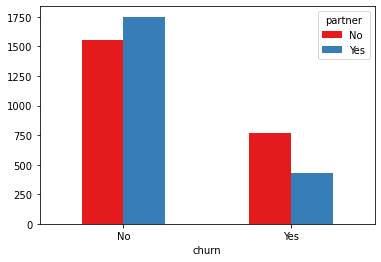

In [18]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Dependents and Churn

- Is there a relationship of customers with dependents and churn rate?

alpha: 0.05

* H0: There is NO relationship between churn and customers with dependents
* Ha: There IS a relationship between churn and customers with dependents

In [19]:
# Chi squared with un-encoded categorical columns
# Null hypothesis: churn rate has no relation to dependents of customers
# Alternative hypothesis: there is a relationship between churn rate and dependents of customers
alpha = 0.05
observed = pd.crosstab(train.churn, train.dependents)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that customers with dependents and churn are independent")

The p-value is 3.091037491736131e-30
Sufficient evidence is present to reject the null hypothesis


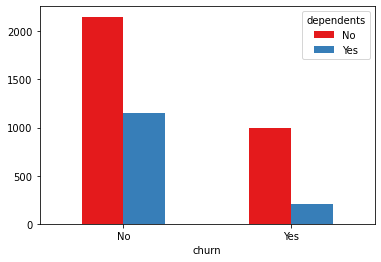

In [20]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between how many customers have partners to churn rate.
* There also does seem to be a relation on customers with dependents and churn rate, however it is clear from the visual above that customers without dependents tend to churn more than those with.

##########################################################################

## Churn vs. Gender:

* H0: There is NO relationship between churn and gender.
* Ha: There IS a relationship between churn and gender.

In [21]:
# Chi squared with un-encoded categorical columns
# Null hypothesis: churn rate has no relation to gender
# Alternative hypothesis: there is a relationship between churn rate and gender
alpha = 0.05
observed = pd.crosstab(train.churn, train.gender)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that gender and churn are independent")

The p-value is 0.23006006175322627
Insufficient evidence to reject the null
Evidence seems to support the claim that gender and churn are independent


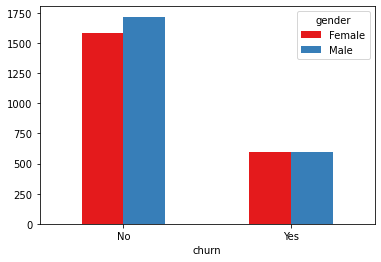

In [22]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
Both Genders churned at almost the same rate within their own categories:
- <b>Female customers: 27% churned</b>
- Male customers: 26% churned
<br>
<br>

### The data shows that there really isn't any relationship between gender and customer churn rate.

##########################################################################

## Churn vs. Is Senior Citizen?

* H0: There is NO relationship between churn and customer being a senior citizen.
* Ha: There IS a relationship between churn and customer being a senior citizen.

In [23]:
# Chi squared with un-encoded categorical columns
# Null hypothesis: churn rate has no relation to senior citizen customers
# Alternative hypothesis: there is a relationship between churn rate and senior citizens
alpha = 0.05
observed = pd.crosstab(train.churn, train.senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that senior_citizens and churn are independent")

The p-value is 1.1002429756735793e-26
Sufficient evidence is present to reject the null hypothesis


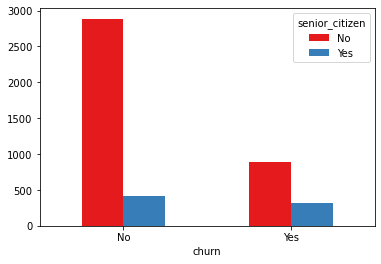

In [24]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
From first glance, because of the low amount of Senior Citizen data count, it looks like customers 59 and younger have more churns. By numbers, YES, 59 and younger DO have more churn, but <b>by churn rate based on its own category, Senior Citizens have the highest churn rate.</b>
- <b>Senior Citizens: 41% churned</b>
- 59 and younger customers: 24% churned

As the p-value shows, in the case that the null Hypothesis is that churn and is_senior_citizen as NO relation,
We would reject the nully Hypothesis as they clearly relate. 

##########################################################################

### NEXT STEPS: 
- It's clear that our drivers for demographics is single and senior citizen customers.
- Using these two key drivers, it's time to compare to subcategories:
        * ✅ non-automated accounts
        * ✅ account types
        * ✅ internet service types

## Non-automated accounts vs. Is Senior Citizen:

* H0: There is NO relationship between non-auto accounts and customer being a senior citizen.
* Ha: There IS a relationship between non-auto accounts and customer being a senior citizen.

In [25]:
train.head(1)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
3270,4673-KKSLS,Female,No,No,No,31,Yes,No,Yes,No,...,0,0,0,0,0,0,1,0,1,0


In [26]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.payment_type, train.senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that senior citizens and auto accounts are independent")

The p-value is 7.76306018553908e-41
Sufficient evidence is present to reject the null hypothesis


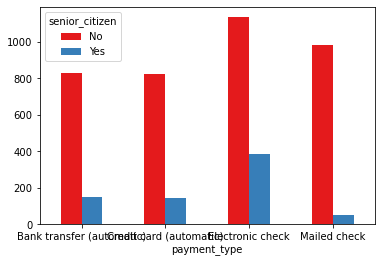

In [27]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between senior citizens and having non-automated accounts.
* The above barplot shows that a large majority of senior citizens actually do have non-automated accounts.
* (This bar plot looks also reminiscent of the is_senior citizen and churn plots).

##########################################################################

## Non-automated accounts vs. Singles (using Partner/Dependant variable):

* H0: There is NO relationship between non-auto accounts and customer being single.
* Ha: There IS a relationship between non-auto accounts and customer being single.

In [28]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.payment_type, train.partner)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that single customers and non-auto accounts are independent")

The p-value is 4.132426205917052e-32
Sufficient evidence is present to reject the null hypothesis


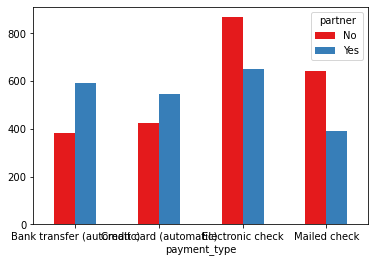

In [29]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between singles having non-automated accounts.
* The above barplot shows that a large majority of singles actually do have non-automated accounts.

##########################################################################

## Internet type accounts vs. Senior Citizen:

Seeing what kind of internet accounts most senior citizens have.

* H0: There is NO relationship between internet type of accounts and customer being a senior citizen.
* Ha: There IS a relationship between internet type of and customer being a senior citizen.

A reminder of what this column is showing:
* 2 = Fiber optic
* 1 = DSL
* 0 = No internet service

In [30]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.internet_service_type, train.senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that senior customers and internet account types are independent")

The p-value is 5.7148487746334794e-64
Sufficient evidence is present to reject the null hypothesis


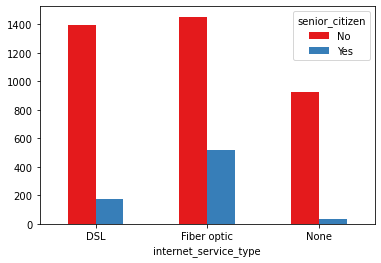

In [31]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

## LOOKING AT HOW CHURN, SENIOR CUSTOMERS and INTERNET SERVICES RELATE

### Take Aways:
* There IS a relationship between seniors and their internet service type accounts.
* The above barplot shows that a large majority of seniors that churned had Fiber Optics for their internet service.

##########################################################################

# Internet type accounts vs. Singles:
Seeing what kind of internet accounts most single customers have.

* H0: There is NO relationship between internet type accounts and single Telco customers.
* Ha: There IS a relationship between internet type and single customer Telco customers.

In [32]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.internet_service_type, train.partner)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that single customers and internet account types are independent")

The p-value is 0.5479078849861201
Insufficient evidence to reject the null
Evidence seems to support the claim that single customers and internet account types are independent


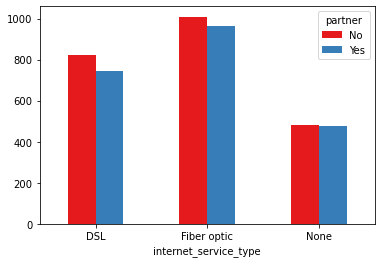

In [33]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There is not a relationship between singles and their internet service type accounts, as I had previously thought.

##########################################################################

# Has Phone accounts vs. Seniors:
Seeing if Seniors have a phone account as well.

* H0: There is NO relationship between phone accounts and Senior citizen Telco customers.
* Ha: There IS a relationship between phone accounts and Senior citizen Telco customers.

NOTE: 
   * 0= No phone service
   * 1= One line
   * 2= Two or More lines

In [34]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.phone_service, train.senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that senior citizen customers and phone account types are independent")

The p-value is 0.9732127844741527
Insufficient evidence to reject the null
Evidence seems to support the claim that senior citizen customers and phone account types are independent


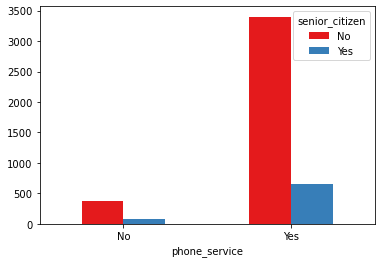

In [35]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### TAKE AWAYS:
- Number of phone lines vs Senior citizens does not relate.

# BUT DOES INTERNET SERVICE RELATE TO CHURN???

- Now that we know our main driving churn demographic and are seeing a relation to Telco's seniors to internet service types, let's just check that churn relates to the internet services with churn as a whole.

## Churn vs Internet Service Type:

* H0: There is not relationship between Churn and Internet Service type.
* Ha: There is a relationship between Churn and Internet Service type.

In [36]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.internet_service_type, train.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that churn and internet account types are independent")

The p-value is 2.4617612720873587e-96
Sufficient evidence is present to reject the null hypothesis


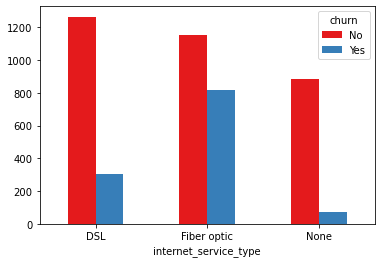

In [37]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between churn and their internet service type accounts.
* More accounts that had Fiber Optic for internet churned than any other internet service type.

##########################################################################

# Seniors and their Subgroups:

In finding that Senior Citizens are some of Telco's highest rated churn customers, 

# My Drivers:
* DEMOGRAPHIC GROUP-
    * Senior Citizen customers 
    * Single customers
* ACCOUNT TYPE GROUPS-
    * Fiber Optic accounts

- More visualizations to show these relationships:

In [38]:
train.columns.tolist()

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type_id.1',
 'contract_type',
 'payment_type_id.1',
 'payment_type',
 'internet_service_type_id.1',
 'internet_service_type',
 'gender_Male',
 'senior_citizen_Yes',
 'partner_Yes',
 'dependents_Yes',
 'phone_service_Yes',
 'multiple_lines_No phone service',
 'multiple_lines_Yes',
 'online_security_No internet service',
 'online_security_Yes',
 'online_backup_No internet service',
 'online_backup_Yes',
 'device_protection_No internet service',
 'device_protection_Yes',
 'tech_support_No internet service',
 'tech_support_Yes',
 'streaming_tv_No internet service',
 'streaming_tv_Yes',
 'streaming_movies_No internet service',
 'streaming_movies_Yes',
 'paperless_billing_Yes',
 '

# Onto ML Models:

### Creating Logistical Regression models:
To quickly assess and models with target (Churn) against chosen variables (Senior citizen, Single, Fiber Optics, non-automated accounts) into a Logistical Regression model. If the accuracy of this model is higher than my baseline, then I'll move onto other models. 

In [39]:
# Dropping categorical and not-needed columns that are leftover.

X_train = train.drop(columns=['churn','customer_id','gender', 'dependents','partner', 
                              'senior_citizen', 'phone_service','multiple_lines','online_security','online_backup',
                              'payment_type','total_charges','device_protection','tech_support','streaming_tv','streaming_movies',
                             'paperless_billing','contract_type','internet_service_type','total_charges'])
y_train = train[['churn']]

X_validate = validate.drop(columns=['customer_id','churn','gender', 'dependents','partner', 
                              'senior_citizen', 'phone_service','multiple_lines','online_security','online_backup',
                              'payment_type','total_charges','device_protection','tech_support','streaming_tv','streaming_movies',
                             'paperless_billing','contract_type','online_security','online_backup',
                              'payment_type','total_charges','device_protection','internet_service_type','total_charges'])
y_validate = validate[['churn']]

X_test = test.drop(columns=['customer_id','churn','gender', 'dependents','partner', 
                              'senior_citizen', 'phone_service','multiple_lines','online_security','online_backup',
                              'payment_type','total_charges','device_protection','tech_support','streaming_tv','streaming_movies',
                             'paperless_billing','contract_type','internet_service_type','total_charges'])
y_test = test[['churn']]

### 1) Developing my baseline to compare my models to:    

- Baseline (for the 'most common case to everything')

In [40]:
#Defining the baseline prediction:
train.churn.mode()
#Mode meaning when a customer did not churn, so our baseline guess would be that a customer will not churn. 


#Calculating the percentage of customers that churned:
train[train['churn'] == False].shape[0] / train.shape[0]

0.0

### My BASELINE IS 73% for accuracy (based on customers that did churn)

In [41]:
train.churn.value_counts(normalize=True)

No     0.734222
Yes    0.265778
Name: churn, dtype: float64

- Defining my x and y:

In [42]:
#checking the x variables
X_train.head(1)

,tenure,monthly_charges,contract_type_id.1,payment_type_id.1,internet_service_type_id.1,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,phone_service_Yes,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
3270,31,87.6,1,1,2,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [43]:
#checking the y (target)variable
y_train.head(1)

,churn
3270,No


### CREATING A LOGISTIC REGRESSION MODEL:::

In [44]:
# Create a simple Logistic Regression model to start.

logit = LogisticRegression(random_state=123)

#### FITTING THE LOGISTICAL REG. MODEL:

In [45]:
logit.fit(X_train, y_train)

LogisticRegression(random_state=123)

- Looking at coefficients to model:

In [46]:
# Create a list of our model features.

features = X_train.columns.tolist()

In [47]:
# Create a list of the weights for each feature from our model.

weights = logit.coef_.flatten()

In [48]:
# Store our lists from above in a DataFrame.

pd.DataFrame(weights, features).reset_index().rename(columns={'index': 'feature', 0: 'weight'})

,feature,weight
0,tenure,-0.030488
1,monthly_charges,0.013701
2,contract_type_id.1,-0.582478
3,payment_type_id.1,-0.127599
4,internet_service_type_id.1,0.152625
5,gender_Male,-0.033843
6,senior_citizen_Yes,0.301938
7,partner_Yes,0.023404
8,dependents_Yes,-0.217353
9,phone_service_Yes,-0.455654


### Evaluating Model:

In [49]:
#Accuracy of the models logistic classifier
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


- Evaluating with classification report:

In [50]:
#making predictions on whether customer churns or not
y_pred = logit.predict(X_train)

In [51]:
#estimating probability of churn based on observations
y_pred_proba = logit.predict_proba(X_train)

In [52]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      3304
         Yes       0.66      0.54      0.59      1196

    accuracy                           0.80      4500
   macro avg       0.75      0.72      0.73      4500
weighted avg       0.79      0.80      0.80      4500



### TAKE AWAYS:
- The first model is already classifying higher than our baseline, so I am on a good track. 
- My recall number is fairly high, so this model was good at predicting TP (aka good at predicting churning)

### THINGS TO NOTE:
* Logistical Regression really helped point out which variables are worth adding/focusing into these models.
(ie internet services, senior citizens)

# Decision Tree Model:

Fitting the decision tree classifier to the Telco training sample and transform (i.e. make predictions on the training sample)

In [53]:
#Creating the model object and fitting it to the training set:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 123)
clf = clf.fit(X_train, y_train)

[Text(362.7, 332.955, 'contract_type_id.1 <= 1.5\ngini = 0.39\nsamples = 4500\nvalue = [3304, 1196]\nclass = did not churn'),
 Text(181.35, 237.825, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.488\nsamples = 2460\nvalue = [1418, 1042]\nclass = did not churn'),
 Text(90.675, 142.695, 'tenure <= 5.5\ngini = 0.407\nsamples = 1138\nvalue = [814, 324]\nclass = did not churn'),
 Text(45.3375, 47.565, 'gini = 0.486\nsamples = 480\nvalue = [280, 200]\nclass = did not churn'),
 Text(136.0125, 47.565, 'gini = 0.306\nsamples = 658\nvalue = [534, 124]\nclass = did not churn'),
 Text(272.025, 142.695, 'tenure <= 13.5\ngini = 0.496\nsamples = 1322\nvalue = [604, 718]\nclass = churned'),
 Text(226.6875, 47.565, 'gini = 0.431\nsamples = 583\nvalue = [183, 400]\nclass = churned'),
 Text(317.3625, 47.565, 'gini = 0.49\nsamples = 739\nvalue = [421, 318]\nclass = did not churn'),
 Text(544.05, 237.825, 'monthly_charges <= 93.675\ngini = 0.14\nsamples = 2040\nvalue = [1886, 154]\nclass = did not ch

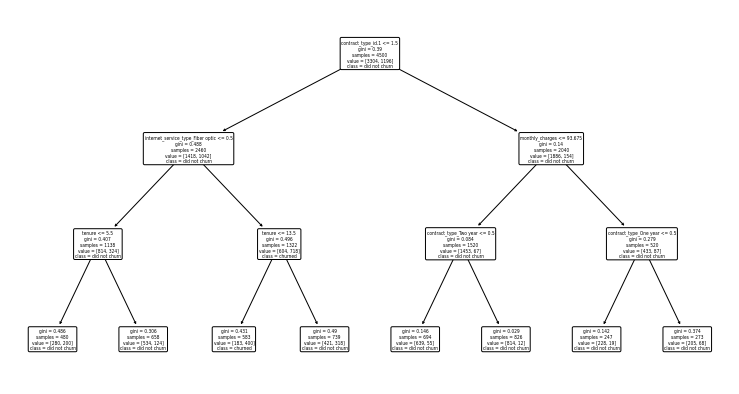

In [54]:
#creating the visual of a Decision Tree model
churned = np.array(['did not churn', 'churned'])

plt.figure(figsize = (13,7))
plot_tree(clf, feature_names = X_train.columns, class_names = churned, rounded = True)

#### EVALUATING DECISION TREE MODEL:

In [55]:
### Make Predictions
y_pred=clf.predict(X_train)
y_pred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [56]:
## Estimate Probability
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.56968877, 0.43031123],
       [0.81155015, 0.18844985],
       [0.92074928, 0.07925072],
       [0.81155015, 0.18844985],
       [0.75091575, 0.24908425]])

In [57]:
#Evaluate by computing accuracy
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.78


In [58]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[3121,  183],
       [ 796,  400]])

In [59]:
#Defining true/false positive and true/false negative:

tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

tn, fp, fn, tp

(3121, 183, 796, 400)

In [60]:
# I'll create a "for" loop so that multiple models can be tested out:
for i in range(2, 21):
    # Make the model
    clf = DecisionTreeClassifier(max_depth=i, random_state=123)
    # Fit the model (on train and only train)
    clf = clf.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = clf.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.849591     0.543116  0.759556     0.696354      0.768137
recall        0.817191     0.600334  0.759556     0.708763      0.759556
f1-score      0.833076     0.570294  0.759556     0.701685      0.763235
support    3304.000000  1196.000000  0.759556  4500.000000   4500.000000

Tree with max depth of 3
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.796783     0.686106  0.782444     0.741445      0.767368
recall        0.944613     0.334448  0.782444     0.639530      0.782444
f1-score      0.864423     0.449691  0.782444     0.657057      0.754197
support    3304.000000  1196.000000  0.782444  4500.000000   4500.000000

Tree with max depth of 4
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.822259     0.623874  0.783111     0.723067      0.769533
recall        0.898910     0.463211  0.783111  

In [61]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.80      0.94      0.86      3304
         Yes       0.69      0.33      0.45      1196

    accuracy                           0.78      4500
   macro avg       0.74      0.64      0.66      4500
weighted avg       0.77      0.78      0.75      4500



### Validate the model:
- comparing in-sample to out-of-sample

In [62]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

          No       0.83      0.83      0.83       826
         Yes       0.54      0.54      0.54       299

    accuracy                           0.75      1125
   macro avg       0.68      0.69      0.68      1125
weighted avg       0.75      0.75      0.75      1125



In [63]:
# Comparing in-sample to out-of-sample values:
dt_metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    dt_metrics.append(output)
    
decision_tree_metrics = pd.DataFrame(dt_metrics)
decision_tree_metrics["difference"] = decision_tree_metrics.train_accuracy - decision_tree_metrics.validate_accuracy
decision_tree_metrics[decision_tree_metrics.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

# It appears that the highest-accuracy decison tree model on the training set has a max depth of 4.

,max_depth,train_accuracy,validate_accuracy,difference
2,4,0.783111,0.804444,-0.021333
5,7,0.814222,0.797333,0.016889
1,3,0.782444,0.795556,-0.013111
4,6,0.802444,0.795556,0.006889
6,8,0.830444,0.792889,0.037556
8,10,0.876000,0.787556,0.088444
3,5,0.795556,0.786667,0.008889
7,9,0.853778,0.779556,0.074222
0,2,0.759556,0.766222,-0.006667


In [64]:
val_df = pd.DataFrame(dt_metrics)
val_df["difference"] = val_df.train_accuracy - val_df.validate_accuracy
val_df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.759556,0.766222,-0.006667
1,3,0.782444,0.795556,-0.013111
2,4,0.783111,0.804444,-0.021333
3,5,0.795556,0.786667,0.008889
4,6,0.802444,0.795556,0.006889
5,7,0.814222,0.797333,0.016889
6,8,0.830444,0.792889,0.037556
7,9,0.853778,0.779556,0.074222
8,10,0.876000,0.787556,0.088444
9,11,0.899778,0.763556,0.136222


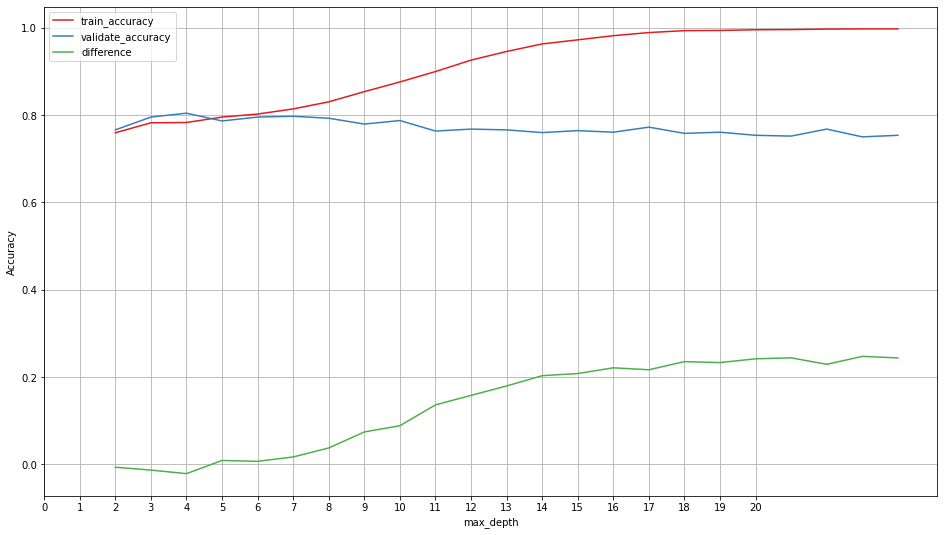

In [65]:
val_df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

### TAKE AWAYS:
- The model with the highest accuracy is the DT with a max depth of 20...the higher it goes, the more accurate it shows, however this kind of test is more prone to over-fitting the data in the model. 
- I would choose a model with a mid range accuracy (around 80+ accuracy and >0.07 for difference)
- <b>My choice here would be going with model 6 or 7 and it fits within the boundaries I listed and there is not a significant increase of difference there.</b>

## Random Forest Model:

In [66]:
from sklearn.ensemble import RandomForestClassifier
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model
forest1.fit(X_train, y_train)

#Using the model
y_predictions = forest1.predict(X_train)

# Adding int the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Forest of 1 depth")
pd.DataFrame(report)

Forest of 1 depth


,No,Yes,accuracy,macro avg,weighted avg
precision,0.734222,0.0,0.734222,0.367111,0.539082
recall,1.000000,0.0,0.734222,0.500000,0.734222
f1-score,0.846745,0.0,0.734222,0.423373,0.621699
support,3304.000000,1196.0,0.734222,4500.000000,4500.000000


In [67]:
# Evaluating our model using a confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,3304,1196
1,0,0


In [68]:
#Using the confusion matrix and predictions to show the TN, TP, FP, FN are:
#this is showing that a True Positive case would be if none were Not Churn, True Negative = all churned
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(0, 3304, 0, 1196)

In [69]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7342222222222222
True Positive Rate: 0.0
False Positive Rate: 0.0
True Negative Rate: 1.0
False Negative Rate: 1.0
Precision: nan
Recall: 0.0
F1 Score: nan
Support (0): 1196
Support (1): 3304


In [70]:
#creating a "for"loop to grab more models quickly:
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Forest with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Forest with max depth of 2
                    No     Yes  accuracy    macro avg  weighted avg
precision     0.734222     0.0  0.734222     0.367111      0.539082
recall        1.000000     0.0  0.734222     0.500000      0.734222
f1-score      0.846745     0.0  0.734222     0.423373      0.621699
support    3304.000000  1196.0  0.734222  4500.000000   4500.000000

Forest with max depth of 3
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.778158     0.707617  0.771778     0.742887      0.759410
recall        0.963983     0.240803  0.771778     0.602393      0.771778
f1-score      0.861160     0.359326  0.771778     0.610243      0.727784
support    3304.000000  1196.000000  0.771778  4500.000000   4500.000000

Forest with max depth of 4
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.799540     0.699491  0.786444     0.749515      0.772949
recall        0.946429     0.344482  0.786444     0.645455      0.

### VALIDATING OUR MODEL WITH OUT OF SAMPLE DATA:

In [71]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
forest_df = pd.DataFrame(metrics)
forest_df["difference"] = forest_df.train_accuracy - forest_df.validate_accuracy
forest_df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.734222,0.734222,0.000000
1,3,0.771778,0.774222,-0.002444
2,4,0.786444,0.792000,-0.005556
3,5,0.795778,0.800000,-0.004222
4,6,0.804444,0.806222,-0.001778
5,7,0.813556,0.808000,0.005556
6,8,0.822667,0.811556,0.011111
7,9,0.843111,0.806222,0.036889
8,10,0.872000,0.809778,0.062222
9,11,0.905556,0.805333,0.100222


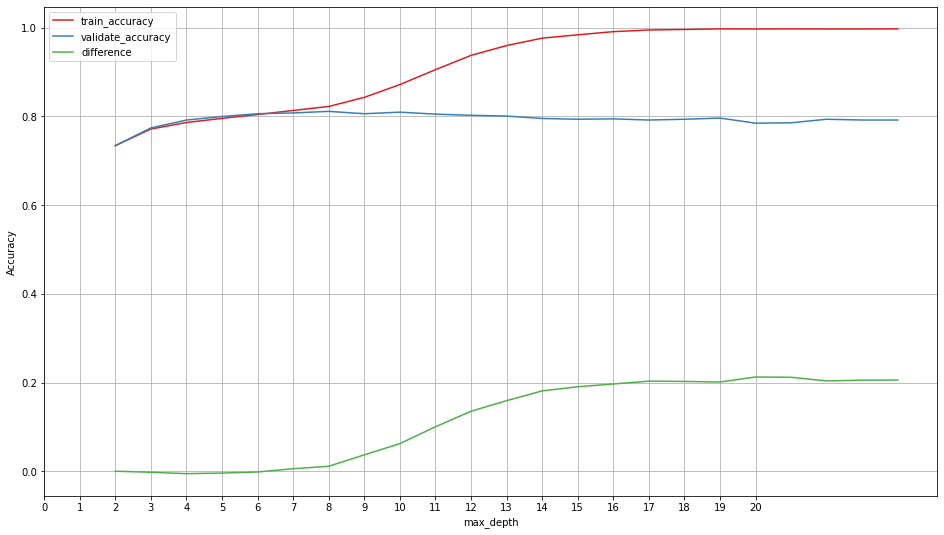

In [72]:
forest_df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

### TAKE AWAY:
- I would choose the RFclassifier with a max depth of 7 as after that number, the difference climbs more than before and the accuracy number is still really good.
- As the graph shows above, after max depth of 7 the Random Forest models of validate and training begin to really seperate. 

### Increasing min_samples_per_leaf, decreasing max_depth (why???)

In [73]:
# Comparing the in sample data with the out sample data
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
forest1_df = pd.DataFrame(metrics)
forest1_df["difference"] = forest1_df.train_accuracy - forest1_df.validate_accuracy
forest1_df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.917778,0.804444,0.113333
1,3,17,0.880889,0.803556,0.077333
2,4,16,0.860444,0.804444,0.056000
3,5,15,0.848889,0.807111,0.041778
4,6,14,0.841333,0.813333,0.028000
5,7,13,0.836889,0.814222,0.022667
6,8,12,0.828667,0.808000,0.020667
7,9,11,0.825333,0.807111,0.018222
8,10,10,0.819556,0.813333,0.006222
9,11,9,0.814667,0.809778,0.004889


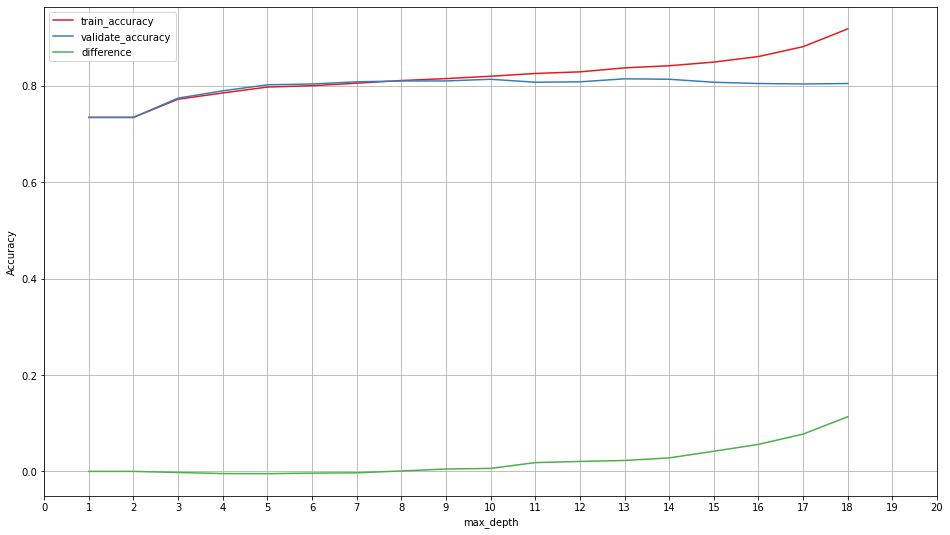

In [74]:
forest1_df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

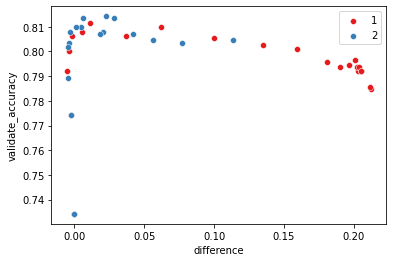

In [75]:
#Comparison of the first model used and second model used. 
first_plot = sns.scatterplot(x="difference", y="validate_accuracy", data=forest_df)
second_plot = sns.scatterplot(x="difference", y="validate_accuracy", data=forest1_df)
plt.legend('12')

### TAKEAWAY: 
- By changing the min samples per leaf w/ max depth, <b>using a max depth of 8 where the separation of validation and training are still close and prior to pulling apart</b> there is still less % of accuracy than the first RF model with a max depth of 4.

## KNN MODELING:

creating the Knn object

In [76]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [77]:
#fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [78]:
#making predictions
y_pred = knn.predict(X_train)

In [79]:
#estimating probabilities
y_pred_proba = knn.predict_proba(X_train)

### Evaluating the Model

In [80]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.82


In [81]:
#creating confusion matrix
print(confusion_matrix(y_train, y_pred))

[[2991  313]
 [ 479  717]]


In [82]:
#Classification report:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.86      0.91      0.88      3304
         Yes       0.70      0.60      0.64      1196

    accuracy                           0.82      4500
   macro avg       0.78      0.75      0.76      4500
weighted avg       0.82      0.82      0.82      4500



### Validate Model

In [83]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.79


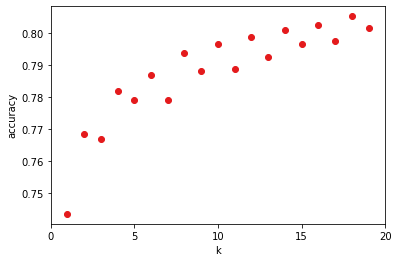

In [84]:
#visualize model
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

### TAKE AWAYS:
- 

# Building some charts:

- Can we take a look at churn with chosen demographics side-by-side? 

In [85]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
3270,4673-KKSLS,Female,No,No,No,31,Yes,No,Yes,No,...,0,0,0,0,0,0,1,0,1,0
6084,8623-ULFNQ,Female,Yes,No,No,26,Yes,Yes,No,No,...,0,1,1,0,0,0,1,0,0,0
4470,6303-KFWSL,Female,No,No,No,29,Yes,Yes,No,Yes,...,0,0,1,1,0,0,1,0,0,0
428,0623-IIHUG,Female,Yes,No,No,21,No,No phone service,Yes,No,...,0,0,1,0,0,0,1,0,0,0
3329,4742-DRORA,Male,No,Yes,Yes,60,Yes,Yes,Yes,No,...,0,0,1,1,0,0,0,0,1,0


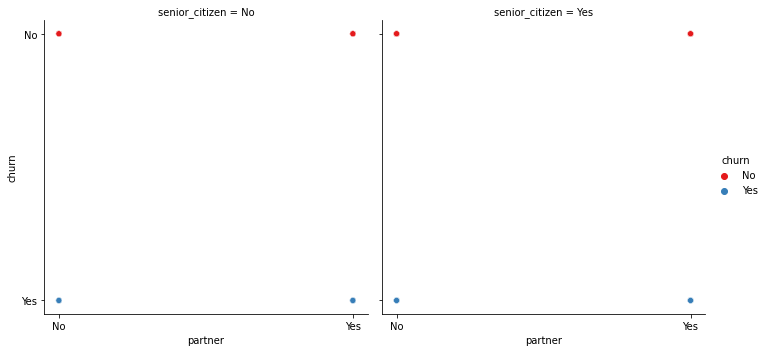

In [86]:
sns.relplot(x="partner", y='churn', hue="churn", col="senior_citizen", data=train )

In [87]:
# Binary encode the target variable
train.churn = train.churn == "Yes"

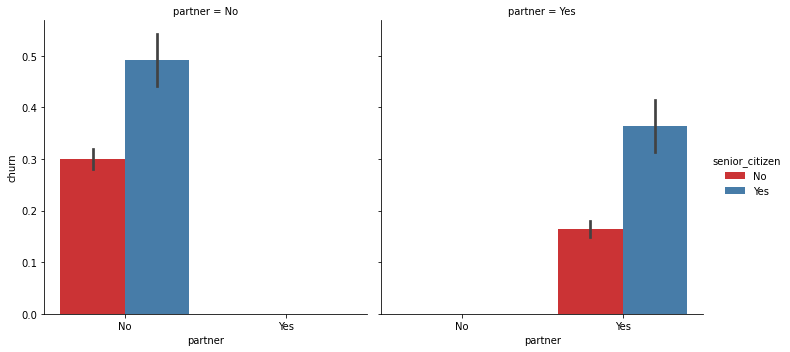

In [88]:
# Set the binary target variable to the y
# Set our first categorical variable to x
# Set a second categorical variable to col
# Set a third categorical variable to hue
sns.catplot(x="partner", y="churn",  hue="senior_citizen", col="partner",data=train, kind="bar")

### TAKE AWAYS:
- This chart looks great, however because I used the excel file, I would need to go back and reset the columns so that the partner_dependants does not look encoded (and would show the string names).

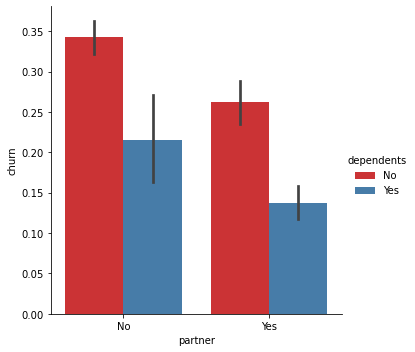

In [89]:
#Relationship between churn, customers having partners and dependents
sns.catplot(x="partner", y ="churn",  hue="dependents",data=train, kind="bar")

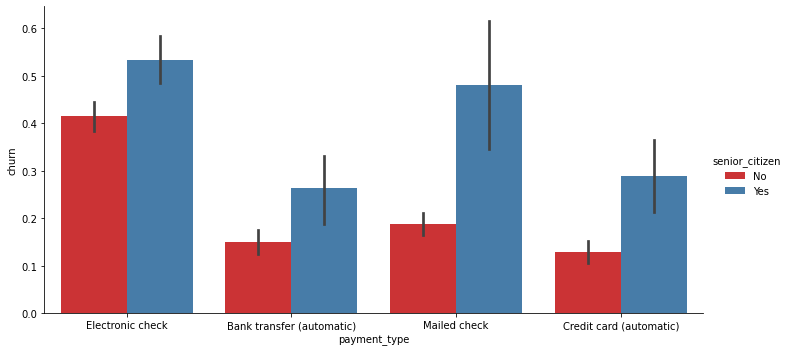

In [90]:
#Relationship between Senior customers and their internet service type against their churn rate
sns.catplot(x="payment_type", y ="churn",  hue="senior_citizen",data=train, kind="bar", height=5, aspect=2)

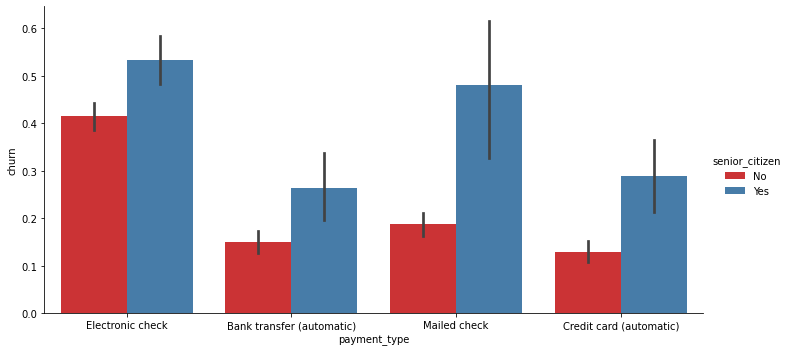

In [91]:
#Relationship between Senior customers and their internet service type against their churn rate
sns.catplot(x="payment_type", y ="churn",  hue="senior_citizen",data=train, kind="bar", height=5, aspect=2)

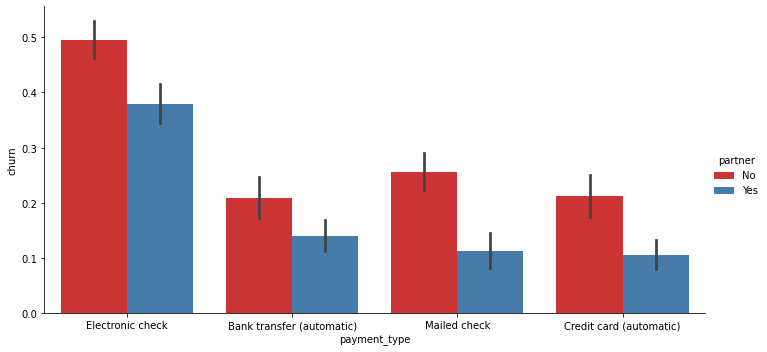

In [92]:
#Relationship between Senior customers and their internet service type against their churn rate
sns.catplot(x="payment_type", y ="churn",  hue="partner",data=train, kind="bar", height=5, aspect=2)

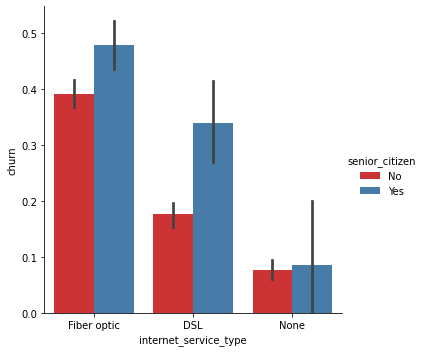

In [93]:
#Relationship between Senior customers and their internet service type against their churn rate
sns.catplot(x="internet_service_type", y ="churn",  hue="senior_citizen",data=train, kind="bar")